In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sdes.sdes import SDE, OrnsteinUhlenbeck
from sdes.tools import plot_simulations, struct_array_to_array, univariate_simulation_test, log_girsanov
plt.style.use('seaborn-v0_8-darkgrid')

Good seeds:

33446

In [2]:
np.random.seed(seed=33446)

In this notebook, we create the plots required for your poster in **Warsaw**! For this, we will run an importance sampler on pathspace. Consider the solvable Ornstein-Uhlenbeck SDE:

$$dX_t = \theta_1(\mu - X_t) dt + \theta_2 dW_t$$

We observe this SDE, with noise, at an ending timepoint $T=1$:

$Y_T | X_T=x_T \sim \mathcal{N}(x_T, \eta^2)$

In this case, the transition density of the process is known:

$X_T | X_0 = x_0 \sim \mathcal{N}(\mu + (x_0 - \mu) e^{-\theta T}, \frac{\sigma^2}{2\theta}[1 -e^{-2\theta T}])$ 

The full parameter vector is given by:

$\theta = (\mu, \theta_1, \theta_2, \eta)$


Since the SDE is time-homogeneous, the transition density only depends on the timestep.

In [3]:
class OrnsteinUhlenbeck(SDE):
    default_params = {'theta_1': 1.0,  
                      'mu': 1.0, 
                      'theta_2': 1.0}

    def b(self, t, x):
        return self.theta_1*(self.mu - x)

    def sigma(self, t, x):
        return self.theta_2 * np.ones_like(x)

We begin by constructing the model SDE:

In [4]:
ou_param_vals = {'theta_1': 1.0,  
              'mu': 0.0, 
              'theta_2': 0.2}
x_0 = 0.
eta = 0.08
T_end = 1.0

ou_sde = OrnsteinUhlenbeck(**ou_param_vals)

Next, we can either generate a simulated value from our model, or define one manually. The marginal distribution of the observation is known analytically, and is given by:

$$Y_T | X_0 = x_0 \sim \mathcal{N}(\mu + (x_0 - \mu) e^{-\theta T}, \frac{\sigma^2}{2\theta}[1-e^{-2\theta (T-t)}] + \eta^2)$$

Thus, the mean and the standard error of our simulation is given by:

In [5]:
obs_mean = ou_param_vals['mu'] + (x_0 - ou_param_vals['mu']) * np.exp(-ou_param_vals['theta_1'] * T_end)
obs_var = (ou_param_vals['theta_2'] ** 2) * (1 - np.exp(-2* ou_param_vals['theta_1'] * T_end)) / (2*ou_param_vals['theta_1']) 
obs_var += eta ** 2      
                            
round(obs_mean, 2), round(np.sqrt(obs_var), 2)

(0.0, 0.15)

We can either set the observation manually below, or simulate the model to generate a value for the data:

In [6]:
dist_kwargs = {'t_start': 0.0,
                   't_end': T_end,
                   'num': 1000}

set_y_obs = True

if set_y_obs:
    y_obs = 0.25
else:    
    ou_sim = ou_sde.simulate(size=1, **dist_kwargs)
    T_str = ou_sim.dtype.names[-1]
    y_obs = ou_sim[T_str] + np.random.normal(scale=eta)

One can show, using Doob's h-transform, that the conditional law of the SDE given the noisy observation, is given by:

$$dX_t = [ \theta_1 (\mu - X_t) + \theta_2^2 \nabla \log(p_{T-t}(y | X_t)) ]dt + \theta_2 dW_t$$

the transition density $p_{T-t}(y | X_t)$ is typically intractable - however in this case it is available analytically:

$Y_T | X_t = x_t \sim \mathcal{N}(\mu + (x_t - \mu) e^{-\theta (T-t)}, \frac{\sigma^2}{2\theta}[1 -e^{-2\theta (T-t)}] + \eta^2)$

We construct the SDE below:

In [7]:
class OptOU(OrnsteinUhlenbeck):
    
    x_star = 1.0
    eta = 0.01

    def b(self, t, x):
        return super().b(t, x) + super().Cov(t, x) * self._grad_log_py(t, x)
    
    def _grad_log_px(self, t, x):
        delta_t = T_end - t
        E = np.exp(-self.theta_1 * delta_t)
        return (2 * self.theta_1) * E * (self.x_star - x * E)/((1 - E ** 2) * self.theta_2 ** 2)
    
    def _grad_log_py(self, t, x):
        delta_t = T_end - t
        E = np.exp(-self.theta_1 * delta_t)
        return E * (y_obs - self._cond_mean(t, x))/(self._cond_var(t, x) + (eta ** 2))
        
    def _cond_mean(self, t, x):
        delta_t = T_end - t
        return self.mu + (x-self.mu)*np.exp(-self.theta_1*delta_t)
    
    def _cond_var(self, t, x):
        delta_t = T_end - t
        return (self.theta_2 ** 2)*(1 - np.exp(-2*self.theta_1*delta_t))/(2*self.theta_1)

In [8]:
opt_ou = OptOU(**ou_param_vals)

We now run importance samplers on pathspace: we use 2 proposals: 

- The bootstrap proposal: simulation from $dX_t = \theta_1(\mu - X_t) dt + \theta_2 dW_t$
- The optimal proposal: simulation from $dX_t = [ \theta_1 (\mu - X_t) + \theta_2^2 \nabla \log(p_{T-t}(y | X_t)) ]dt + \theta_2 dW_t$

For the bootstrap proposal, our weights are simply given by the observation density:

$Y_T | X_T=x_T \sim \mathcal{N}(x_T, \eta^2)$

When the value of $\eta$ is low, this likelihood is highly informative. Unless proposals are chosen appropriately, we will obtain weights with high variance, which corresponds to poor performance.

For the optimal proposal, the weight is given by the product of the observation density above, and the continuous-time likelihood between the model SDE and the proposal SDE: $G(X_{[0,T]})$, which is given by Girsanov's theorem:

$$\log(G(X_{[0,T]}) = \int_{0}^T \frac{b_2(X_t) - b_1(X_t)}{\sigma(X_t)} dX_t - \frac{1}{2} \int_{0}^T \frac{b_2^2(X_t) - b_1^2(X_t)}{\sigma(X_t)}dt$$

The log observation density is defined below:

In [9]:
def log_obs_density(x):
    return stats.norm.logpdf(x, loc=y_obs, scale=eta)

We generate simulations from both the bootstrap and the optimal proposal SDEs below:

In [10]:
N = 10

boot_ou_sims = ou_sde.simulate(size=N, **dist_kwargs)
opt_ou_sims = opt_ou.simulate(size=N, **dist_kwargs)

Next, we evalute weights for the optimal proposal:

In [11]:
X = opt_ou_sims; proposal_sde = opt_ou; target_sde = ou_sde

array_X = struct_array_to_array(X).T
names = X.dtype.names; delta = float(names[1]) - float(names[0])
times = np.array([float(name) for name in names])
b_1 = proposal_sde.b; b_2 = target_sde.b; sigma = target_sde.sigma
B_1 = b_1(times, array_X)[:, :-1]
B_2 = b_2(times, array_X)[:, :-1] 
Sigma = sigma(times, array_X)[:, :-1]

In [12]:
log_g_wts_opt = log_girsanov(opt_ou_sims, ou_sde, opt_ou)
log_obs_wts_opt = log_obs_density(opt_ou_sims['1.0'])

W_opt = np.exp(log_g_wts_opt + log_obs_wts_opt)
W_opt = W_opt/W_opt.sum()

And evaluate weights for the bootstrap proposal:

In [13]:
log_obs_wts_boot = log_obs_density(boot_ou_sims['1.0'])
W_boot = np.exp(log_obs_wts_boot)
W_boot = W_boot/W_boot.sum()

Given our weights, we can calculate effective sample sizes for both of our proposals:

In [14]:
ESS_opt_prop = 1/np.square(W_opt).sum()
ESS_boot_prop = 1/np.square(W_boot).sum()

In [15]:
ESS_opt_prop, ESS_boot_prop

(8.959839079811124, 2.534598655684168)

# Plot for Poster!!!

In [16]:
boot_alphas = np.where(W_boot < 0.4, 0.1, 1.0)
opt_alphas = W_opt * 1/np.max(W_opt)

In [19]:
import os

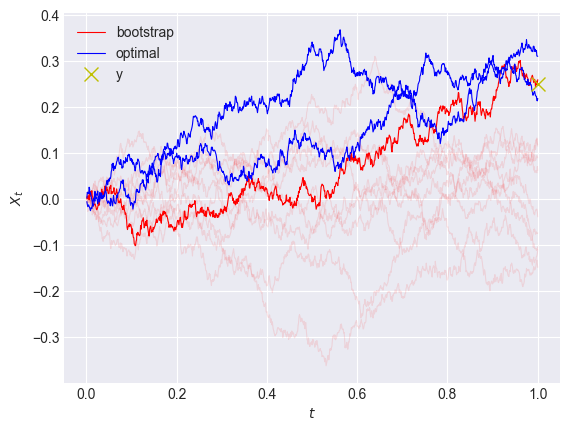

In [18]:
fig, ax = plt.subplots()
t_s = np.array([[float(name) for name in boot_ou_sims.dtype.names]])
boot_data = struct_array_to_array(boot_ou_sims)
opt_data = struct_array_to_array(opt_ou_sims)
for i in range(10):
    if boot_alphas[i] == 1:
        ax.plot(t_s.T, boot_data[:, i], c='r', alpha = boot_alphas[i], lw=0.8, label='bootstrap');
    else:
        ax.plot(t_s.T, boot_data[:, i], c='r', alpha = boot_alphas[i], lw=0.8);
ax.plot(t_s.T, opt_data[:, 0], c='b', lw=0.8)
ax.plot(t_s.T, opt_data[:, 1], c='b', lw=0.8, label='optimal')    
ax.plot([1.], [y_obs], 'x', markersize=10., c='y', label='y')

ax.set_xlabel('$t$')
ax.set_ylabel('$X_t$')
ax.legend()
plt.savefig('./guided_proposal.png')